<a href="https://colab.research.google.com/github/ego-alt/segmentation-from-scratch/blob/master/00_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-human.tgz
!tar zxvf *-images.tgz
!tar zxvf *-human.tgz

In [77]:
import re
import os.path
import numpy as np
from PIL import Image
from torch import nn, from_numpy, cat, cuda, randn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt

In [ ]:
root_dir = "./BSDS300"
train_data = os.path.join(root_dir, 'images/train')
test_data = os.path.join(root_dir, 'images/test')
labels = os.path.join(root_dir, 'human/color')

In [ ]:
def extract_labels(label_files):
    """Converts segmentation data from .seg files into np.array"""
    meta = {}
    data = []
    with open(label_files, 'r') as f:
        matcher = re.compile('(?P<seg>^[0-9 ]+)')
        for line in f:
            seg_match = matcher.search(line)
            if seg_match:
                string_segment = seg_match.group('seg').split(' ')
                int_segment = np.asarray(string_segment, dtype=int)
                data.append(int_segment)
                continue
            elif "data" not in line:
                meta_data = line.strip('\n').split(' ', 1)
                index, value = meta_data[0], meta_data[1]
                meta[index] = value
    height, width = int(meta['height']), int(meta['width'])
    seg_num = int(meta['segments'])
    # print(f"User id: {meta['user']}     Image id: {meta['image']}")
    # print(f"Height: {height}       Width: {width}")
    segmentation = np.zeros((height, width))
    for seg in data:
        segmentation[seg[1], seg[2]:(seg[3] + 1)] = seg[0]
    return segmentation, seg_num

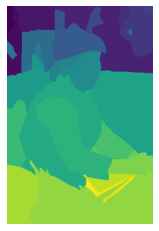

In [ ]:
def create_image(seg_val, seg_max):
    """Creates an image using extracted segmentation data"""
    seg_val = (seg_val / seg_max) * 255
    plt.figure()
    plt.axis('off')
    plt.imshow(seg_val)
    plt.show()

# To test whether extracting segmentations is successful
test = os.path.join(labels, '1105/15004.seg')
segmentation, seg_num = extract_labels(test)
create_image(segmentation, seg_num)

In [ ]:
class CropArrayCentre(object):
    """Custom transform to crop the centre of arrays (both images and segmentations)"""
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample["image"], sample["label"]
        y, x, _ = image.shape
        image = self.crop(image, x, y)
        label = self.crop(label, x, y)
        return {'image': image, 'label': label}

    def crop(self, sample, x, y):
        crop_y, crop_x = self.output_size
        start_x, start_y = x // 2 - (crop_x // 2), y // 2 - (crop_y // 2)
        return sample[start_y: start_y + crop_y, start_x: start_x + crop_x]


class TwoTensor(object):
    """Custom transform to convert arrays (both images and segmentations) to tensors"""
    def __call__(self, sample):
        image, label = sample["image"], sample["label"]
        image, label = from_numpy(image).permute(2, 0, 1), from_numpy(label)
        return {'image': image, 'label': label}

In [ ]:
class Berkeley(Dataset):
    """Custom dataset containing training/test data + their respective labels"""
    def __init__(self, image_files, label_files):
        """Images and labels are converted into np.arrays and listed in ascending index
        :param image_files: Path to images
        :param label_files: Path to segmentation labels"""
        self.images, self.labels = self.array_from_path(image_files, label_files)
        self.transform = transforms.Compose([
            CropArrayCentre(321),  # Crops image + segmentation to uniform size
            TwoTensor()  # Converts image + segmentation np.array to torch.tensor
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        sample = {"image": self.images[index], "label": self.labels[index]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def array_from_path(self, image_files, label_files):
        images = sorted([img for img in os.listdir(image_files)])  # List in format .jpg
        image_names = [os.path.splitext(img)[0] for img in images]  # List of image ids (sans .jpg)
        ordered_files = {}
        for root, user_folder, files in os.walk(label_files):
            for file in files:
                file_name = os.path.splitext(file)[0]
                if file_name in image_names:
                    file_path = os.path.join(root, file)
                    seg, _ = extract_labels(file_path)
                    ordered_files[file_name] = seg

        images = [np.asarray(Image.open(os.path.join(image_files, img))) for img in images]
        labels = [value for _, value in sorted(ordered_files.items(), key=lambda ele: ele[0])]
        return images, labels

In [ ]:
train_loader = DataLoader(Berkeley(train_data, labels), batch_size=25)

In [ ]:
test_loader = DataLoader(Berkeley(test_data, labels), batch_size=25)

0 torch.Size([25, 3, 321, 321]) torch.Size([25, 321, 321])
1 torch.Size([25, 3, 321, 321]) torch.Size([25, 321, 321])
2 torch.Size([25, 3, 321, 321]) torch.Size([25, 321, 321])
3 torch.Size([25, 3, 321, 321]) torch.Size([25, 321, 321])
4 torch.Size([25, 3, 321, 321]) torch.Size([25, 321, 321])
5 torch.Size([25, 3, 321, 321]) torch.Size([25, 321, 321])


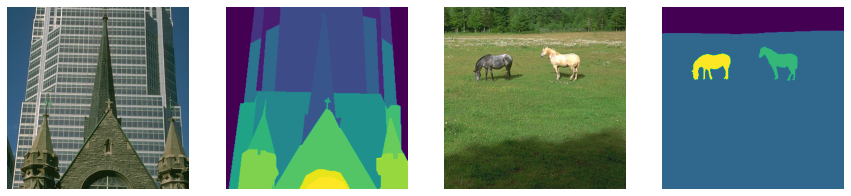

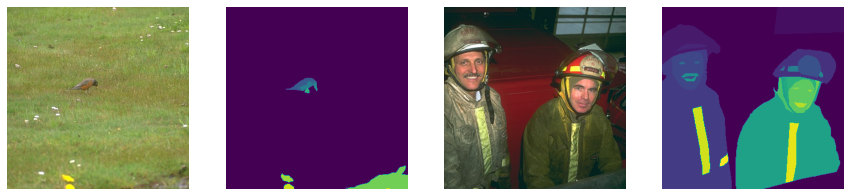

In [ ]:
def show_images(sample_batched, i):
    """Show images and segmentation side-by-side in a batch of samples"""
    images_batch, labels_batch = sample_batched['image'], sample_batched['label']
    image_0, seg_0 = (images_batch[i].permute(1, 2, 0)), (labels_batch[i])
    image_1, seg_1 = (images_batch[i+1].permute(1, 2, 0)), (labels_batch[i+1])
    four_show = [image_0, seg_0, image_1, seg_1]
    
    for ind in range(len(four_show)):
      axarr[ind].imshow(four_show[ind])
      axarr[ind].axis('off')

for i_batch, sample_batched in enumerate(train_loader):
    if i_batch == 5: # Stop and examine a specific batch
      for ind in range(0,4,2):
        f, axarr = plt.subplots(1,4, figsize=(15,15)) 
        show_images(sample_batched, ind)
        plt.ioff()
        plt.show()
      break

In [8]:
device = 'cuda' if cuda.is_available else 'cpu'
print(f'Using {device} device')

Using cuda device


In [78]:
class Block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, (3, 3)),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.stack(x)
        return x

In [26]:
class UNet(nn.Module):
    def __init__(self, channels):
        super(UNet, self).__init__()
        self.down, self.up = channels, [c for c in reversed(channels[1:])]  # Number of feature channels
        self.down_layers, self.up_layers = nn.ModuleList(), nn.ModuleList()
        self.build_layers()  # Generate list of required modules
        self.features = []

    def forward(self, model):
        model = self.contracting(model)
        model = self.expansive(model)
        return model

    def build_layers(self):
        # Generate sequence layer for the contracting path
        for i in range(len(self.down) - 1):
            self.down_layers.append(Block(self.down[i], self.down[i + 1]))
            if i < max(range(len(self.down) - 1)):
                self.down_layers.append(nn.MaxPool2d((2, 2), stride=2))

        # Generate sequence layer for the expansive path
        for i in range(len(self.up) - 1):
            self.up_layers.append(nn.ConvTranspose2d(self.up[i], self.up[i + 1], (2, 2), stride=2))
            self.up_layers.append(Block(self.up[i], self.up[i + 1]))
        self.up_layers.append(nn.Conv2d(self.up[-1], 2, (1, 1)))

    def contracting(self, model):
        """3x3 convolutions & ReLU followed by 2x2 max pooling for downsampling"""
        for i in range(0, len(self.down_layers) - 1, 2):
            block = self.down_layers[i](model)
            self.features.append(block)
            model = self.down_layers[i + 1](block)
        model = self.down_layers[-1](model)
        return model

    def expansive(self, model):
        """Upsampling followed by 3x3 convolutions & ReLU"""
        for i in range(0, len(self.up_layers) - 1, 2):
            block = self.up_layers[i](model)
            _, _, h, w = block.shape
            feature = transforms.CenterCrop([h, w])(self.features[(len(self.up)) - int(i / 2) - 2])
            # Double the number of feature channels through concatenation
            block = cat([block, feature], dim=1)
            model = self.up_layers[i + 1](block)
        model = self.up_layers[-1](model)
        return model

In [29]:
x = randn(1, 1, 572, 572)
channels = [1, 64, 128, 256, 512, 1024]
handler = UNet(channels)
x = handler(x)
x.shape